In [2]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import stats  # For statistical tests
import matplotlib.pyplot as plt  # For plotting (optional)

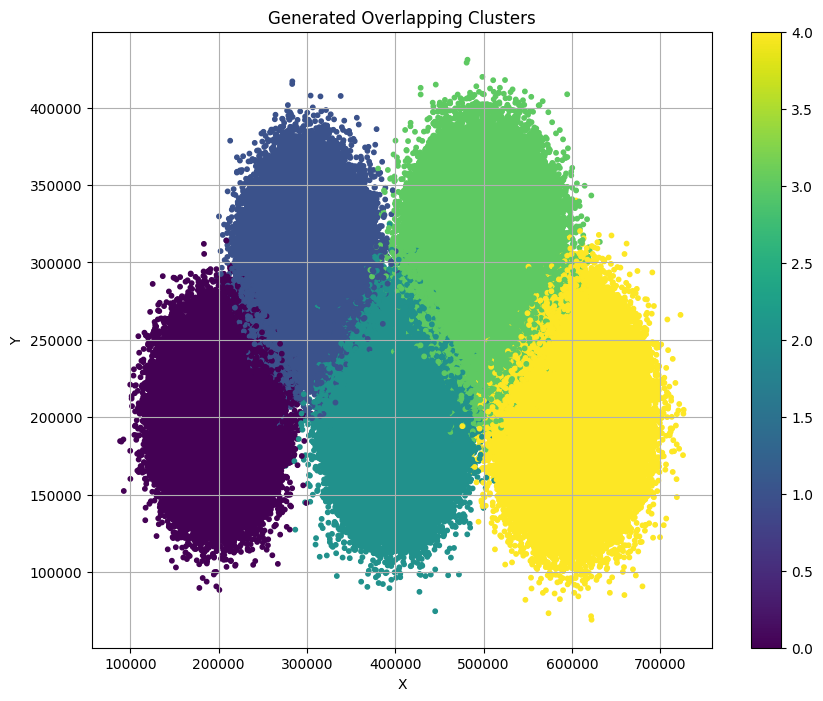

In [3]:
# Define cluster centers (similar to means in your original setup)
centers = [
    [200000, 200000],  # Cluster 1
    [300000, 300000],  # Cluster 2
    [400000, 200000],  # Cluster 3
    [500000, 300000],  # Cluster 4
    [600000, 200000]   # Cluster 5
]

# Define standard deviations (similar to variance) for each cluster
cluster_std = [25000, 25000, 27000, 30000, 29000]  # These control spread of clusters

data, true_labels = make_blobs(n_samples=1000000, centers=centers, cluster_std=cluster_std, random_state=42)

# Plotting the generated clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data[:, 0], data[:, 1], c=true_labels, cmap='viridis', s=10)
plt.colorbar(scatter)
plt.title("Generated Overlapping Clusters")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()                                                                    # Optimized initialization with vectorized operations for distance calculation

In [4]:
def initialize_centroids(data, k):
    n_samples, _ = data.shape
    centroids = []
    # Randomly select the first centroid
    centroids.append(data[random.randint(0, n_samples - 1)])

    # Array to store the minimum distances to the closest centroid
    distances = np.full(n_samples, np.inf)

    for _ in range(1, k):
        # Vectorized calculation of distances from all data points to the latest centroid
        new_distances = np.linalg.norm(data - centroids[-1], axis=1) ** 2

        # Update the minimum distances to the nearest centroid
        distances = np.minimum(distances, new_distances)

        # Normalize distances to get probabilities
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()

        # Select a new centroid based on cumulative probabilities
        centroids.append(data[np.searchsorted(cumulative_probabilities, r)])

    return np.array(centroids)

def compute_potential(data, labels, centroids):
    potential = 0.0
    for i, centroid in enumerate(centroids):
        potential += np.sum((data[labels == i] - centroid) ** 2)
    return potential                                                                  # Set the number of clusters
k = len(centers)
num_trials = 2 ** k  # Number of trials

optimal_potential = compute_potential(data, true_labels, centers)
def run_kmeans_and_compute_potential(data, k):
    # Initialize centroids using the vanilla K-means++ method
    initial_centroids = initialize_centroids(data, k)

    # Use custom centroids in KMeans
    kmeans = KMeans(n_clusters=k, init=initial_centroids, max_iter=300, n_init=1, random_state=None)
    kmeans.fit(data)
    
    final_centroids = kmeans.cluster_centers_
    final_labels = kmeans.labels_
    final_potential = compute_potential(data, final_labels, final_centroids)
    
    return final_potential

# Run 2^k trials and store the final potentials
final_potentials = []
for trial in range(num_trials):
    final_potential = run_kmeans_and_compute_potential(data, k)
    final_potentials.append(final_potential)        

In [6]:
# Run trials and track the minimal potential with the smaller dataset
min_potential = float('inf')
best_centroids = None
best_labels = None

for trial in range(num_trials):
    centroids, labels, potential = run_kmeans_and_compute_potential(data, k)
    if potential < min_potential:
        min_potential = potential
        best_centroids = centroids
        best_labels = labels

# Plot the best cluster result from the smaller dataset
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data[:, 0], data[:, 1], c=best_labels, cmap='viridis', s=10)
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.colorbar(scatter)
plt.title("Clusters with Minimal Potential (Reduced Dataset)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


TypeError: cannot unpack non-iterable numpy.float64 object

In [1]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import stats  # For statistical tests
import matplotlib.pyplot as plt  # For plotting (optional)

# Function to initialize centroids (same as before)
def initialize_centroids(data, k):
    n_samples, _ = data.shape
    centroids = []
    # Randomly select the first centroid
    centroids.append(data[random.randint(0, n_samples - 1)])

    # Array to store the minimum distances to the closest centroid
    distances = np.full(n_samples, np.inf)

    for _ in range(1, k):
        # Vectorized calculation of distances from all data points to the latest centroid
        new_distances = np.linalg.norm(data - centroids[-1], axis=1) ** 2

        # Update the minimum distances to the nearest centroid
        distances = np.minimum(distances, new_distances)

        # Compute probabilities proportional to the squared distances
        probabilities = distances / distances.sum()

        # Choose the next centroid randomly according to the probabilities
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()
        index = np.searchsorted(cumulative_probabilities, r)
        centroids.append(data[index])

    return np.array(centroids)

# Function to compute the potential (sum of squared distances)
def compute_potential(data, labels, centroids):
    potential = 0.0
    for i, centroid in enumerate(centroids):
        # Select data points belonging to cluster i
        cluster_points = data[labels == i]
        # Compute squared distances and sum them
        distances = np.linalg.norm(cluster_points - centroid, axis=1) ** 2
        potential += distances.sum()
    return potential

# Main experiment
k_values = [3, 4, 5]
N = 30  # Number of datasets (repetitions)
c = 2  # Constant-factor approximation threshold

# Dictionaries to store results for each k
mean_proportions = {}
std_proportions = {}
all_proportions = {}  # To store proportions for statistical tests

for k in k_values:
    print(f"\nRunning experiments for k = {k}")
    num_trials = 2 ** k  # Number of trials
    proportions = []  # To store success proportions for each dataset

    for dataset_num in range(N):
        # Generate random cluster centers and standard deviations
        centers = np.random.uniform(low=100000, high=600000, size=(k, 2))
        cluster_std = np.random.uniform(low=20000, high=30000, size=k)

        # Generate the data
        data, true_labels = make_blobs(n_samples=1000000, centers=centers, cluster_std=cluster_std, random_state=90139)

        # Compute the optimal potential using true centers and true labels
        optimal_potential = compute_potential(data, true_labels, centers)

        constant_factor_count = 0  # Counter for constant-factor approximations in this dataset

        for trial in range(num_trials):
            # Initialize centroids and run KMeans
            initial_centroids = initialize_centroids(data, k)
            kmeans = KMeans(n_clusters=k, init=initial_centroids, max_iter=100, n_init=1, random_state=90139)
            kmeans.fit(data)

            final_centroids = kmeans.cluster_centers_
            final_labels = kmeans.labels_
            final_potential = compute_potential(data, final_labels, final_centroids)

            normalized_potential = final_potential / optimal_potential

            # Check if the normalized potential is less than or equal to c
            if normalized_potential <= c:
                constant_factor_count += 1

        # Compute the success proportion for this dataset
        success_proportion = constant_factor_count / num_trials
        proportions.append(success_proportion)

        print(f"Dataset {dataset_num + 1}/{N} for k={k}: Success proportion = {success_proportion:.4f}")

    # Compute mean and standard deviation of success proportions for this k
    mean_proportion = np.mean(proportions)
    std_proportion = np.std(proportions, ddof=1)

    mean_proportions[k] = mean_proportion
    std_proportions[k] = std_proportion
    all_proportions[k] = proportions  # Store for statistical tests

    # Compute standard error
    SE = std_proportion / np.sqrt(N)

    # Construct confidence interval (e.g., 95% confidence interval)
    z = 1.96  # For 95% confidence
    CI_lower = mean_proportion - z * SE
    CI_upper = mean_proportion + z * SE

    print(f"\nFor k = {k}:")
    print(f"Mean success proportion: {mean_proportion:.4f}")
    print(f"Standard deviation: {std_proportion:.4f}")
    print(f"95% Confidence interval for the mean success proportion: [{CI_lower:.4f}, {CI_upper:.4f}]")

# At this point, you have mean_proportions and std_proportions dictionaries containing the results for k=3,4,5



Running experiments for k = 3
Dataset 1/30 for k=3: Success proportion = 0.8750
Dataset 2/30 for k=3: Success proportion = 1.0000
Dataset 3/30 for k=3: Success proportion = 0.8750


KeyboardInterrupt: 

In [ ]:
# Collect the success proportions for each k
proportions_k3 = all_proportions[3]
proportions_k4 = all_proportions[4]
proportions_k5 = all_proportions[5]

# Perform one-way ANOVA
F_statistic, p_value = stats.f_oneway(proportions_k3, proportions_k4, proportions_k5)

print("\nOne-way ANOVA results:")
print(f"F-statistic: {F_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The differences in mean success proportions across different k are statistically significant.")
else:
    print("No statistically significant differences were found in mean success proportions across different k.")

# If significant, perform post-hoc tests (Tukey's HSD)
# Since scipy doesn't have Tukey's HSD, we'll use statsmodels
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data for Tukey's HSD
data = proportions_k3 + proportions_k4 + proportions_k5
groups = (['k=3'] * N) + (['k=4'] * N) + (['k=5'] * N)
df = pd.DataFrame({'Success_Proportion': data, 'Group': groups})

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['Success_Proportion'], groups=df['Group'], alpha=0.05)

print("\nTukey's HSD test results:")
print(tukey)

# Optional: Plot the results
tukey.plot_simultaneous()
plt.title("Tukey HSD Test for Success Proportions Across k")
plt.xlabel("Success Proportion")
plt.show()


In [ ]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import stats  # For statistical tests
import matplotlib.pyplot as plt  # For plotting (optional)
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Function to initialize centroids (same as before)
def initialize_centroids(data, k):
    n_samples, _ = data.shape
    centroids = []
    # Randomly select the first centroid
    centroids.append(data[random.randint(0, n_samples - 1)])

    # Array to store the minimum distances to the closest centroid
    distances = np.full(n_samples, np.inf)

    for _ in range(1, k):
        # Vectorized calculation of distances from all data points to the latest centroid
        new_distances = np.linalg.norm(data - centroids[-1], axis=1) ** 2

        # Update the minimum distances to the nearest centroid
        distances = np.minimum(distances, new_distances)

        # Compute probabilities proportional to the squared distances
        probabilities = distances / distances.sum()

        # Choose the next centroid randomly according to the probabilities
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()
        index = np.searchsorted(cumulative_probabilities, r)
        centroids.append(data[index])

    return np.array(centroids)

# Function to compute the potential (sum of squared distances)
def compute_potential(data, labels, centroids):
    potential = 0.0
    for i, centroid in enumerate(centroids):
        # Select data points belonging to cluster i
        cluster_points = data[labels == i]
        # Compute squared distances and sum them
        distances = np.linalg.norm(cluster_points - centroid, axis=1) ** 2
        potential += distances.sum()
    return potential

# Main experiment
k_values = [3, 4, 5]
N = 30  # Number of datasets (repetitions)
c = 2  # Constant-factor approximation threshold
delta = 3  # Threshold for early stopping (three-sigma rule)

# Dictionaries to store results for each k
results = {}

for k in k_values:
    print(f"\nRunning experiments for k = {k}")
    N_min = k  # Minimum number of trials before checking early stopping
    N_max = 2 ** k  # Maximum number of trials
    early_stop_counts = []  # Number of trials before early stopping
    success_flags = []      # Whether a constant-factor approximation was achieved
    normalized_potentials_at_stop = []  # Normalized potentials at early stopping

    for dataset_num in range(N):
        print(f"Dataset {dataset_num + 1}/{N} for k={k}")
        # Generate random cluster centers and standard deviations
        centers = np.random.uniform(low=100000, high=600000, size=(k, 2))
        cluster_std = np.random.uniform(low=25000, high=30000, size=k)

        # Generate the data
        data, true_labels = make_blobs(n_samples=1000000, centers=centers, cluster_std=cluster_std, random_state=90139)

        # Compute the optimal potential using true centers and true labels
        optimal_potential = compute_potential(data, true_labels, centers)

        # Initialize list to store normalized potentials
        normalized_potentials = []

        N_stop = 0  # Number of trials before early stopping
        success_flag = False  # Whether a constant-factor approximation was achieved

        for trial in range(1, N_max + 1):
            # Initialize centroids and run KMeans
            initial_centroids = initialize_centroids(data, k)
            kmeans = KMeans(n_clusters=k, init=initial_centroids, max_iter=100, n_init=1, random_state=90139)
            kmeans.fit(data)

            final_centroids = kmeans.cluster_centers_
            final_labels = kmeans.labels_
            final_potential = compute_potential(data, final_labels, final_centroids)

            normalized_potential = final_potential / optimal_potential
            normalized_potentials.append(normalized_potential)

            N_stop = trial  # Update number of trials

            # After minimum number of trials, check early stopping condition
            if trial >= N_min:
                # Compute mean and standard deviation of normalized potentials observed so far
                mu = np.mean(normalized_potentials)
                sigma = np.std(normalized_potentials, ddof=1)
                # Avoid division by zero
                if sigma == 0:
                    sigma = 1e-8
                # Check early stopping condition
                stability_condition = abs(normalized_potential - mu) <= delta * sigma
                quality_condition = normalized_potential <= c

                if stability_condition and quality_condition:
                    success_flag = True
                    # Record the normalized potential at early stopping
                    normalized_potential_at_stop = normalized_potential
                    break  # Early stopping

        # If the loop completed without early stopping
        if not success_flag:
            # Even if early stopping did not occur, check if any trial achieved a constant-factor approximation
            success_flag = any(np.array(normalized_potentials) <= c)
            normalized_potential_at_stop = normalized_potentials[-1]  # Last normalized potential

        early_stop_counts.append(N_stop)
        success_flags.append(success_flag)
        normalized_potentials_at_stop.append(normalized_potential_at_stop)

        print(f"Early stopped after {N_stop} trials. Success: {success_flag}. Normalized potential at stop: {normalized_potential_at_stop:.4f}")

    # Compute statistics
    mean_N_stop = np.mean(early_stop_counts)
    std_N_stop = np.std(early_stop_counts, ddof=1)
    mean_normalized_potential = np.mean(normalized_potentials_at_stop)
    std_normalized_potential = np.std(normalized_potentials_at_stop, ddof=1)
    success_rate = np.mean(success_flags)

    # Compute standard error for N_stop
    SE_N_stop = std_N_stop / np.sqrt(N)

    # Compute confidence interval for mean N_stop
    z = 1.96  # For 95% confidence
    CI_lower_N_stop = mean_N_stop - z * SE_N_stop
    CI_upper_N_stop = mean_N_stop + z * SE_N_stop

    print(f"\nFor k = {k}:")
    print(f"Mean number of trials before early stopping: {mean_N_stop:.2f}")
    print(f"Standard deviation: {std_N_stop:.2f}")
    print(f"95% Confidence interval for mean number of trials: [{CI_lower_N_stop:.2f}, {CI_upper_N_stop:.2f}]")
    print(f"Success rate: {success_rate:.4f}")
    print(f"Mean normalized potential at early stopping: {mean_normalized_potential:.4f}")
    print(f"Standard deviation of normalized potential at early stopping: {std_normalized_potential:.4f}")

    # Store results for statistical analysis
    results[k] = {
        'early_stop_counts': early_stop_counts,
        'success_flags': success_flags,
        'normalized_potentials_at_stop': normalized_potentials_at_stop,
    }

# At this point, you have results dictionary containing the data for k=3,4,5

# Statistical Analysis

# Collect early_stop_counts for each k
N_stop_k3 = results[3]['early_stop_counts']
N_stop_k4 = results[4]['early_stop_counts']
N_stop_k5 = results[5]['early_stop_counts']

# Perform one-way ANOVA on the number of trials before early stopping
F_statistic, p_value = stats.f_oneway(N_stop_k3, N_stop_k4, N_stop_k5)

print("\nOne-way ANOVA results on number of trials before early stopping:")
print(f"F-statistic: {F_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The differences in mean number of trials before early stopping across different k are statistically significant.")
    # Perform Tukey's HSD test
    # Prepare data for Tukey's HSD
    data_N_stop = N_stop_k3 + N_stop_k4 + N_stop_k5
    groups_N_stop = (['k=3'] * N) + (['k=4'] * N) + (['k=5'] * N)
    df_N_stop = pd.DataFrame({'N_stop': data_N_stop, 'Group': groups_N_stop})

    tukey_N_stop = pairwise_tukeyhsd(endog=df_N_stop['N_stop'], groups=df_N_stop['Group'], alpha=0.05)

    print("\nTukey's HSD test results for number of trials before early stopping:")
    print(tukey_N_stop)
else:
    print("No statistically significant differences were found in mean number of trials before early stopping across different k.")
